In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 f

In [2]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType,ElectronicStructureMoleculeDriver

molecule = Molecule(
    geometry=[["H",[0.0,0.0,0.0]],
              ["H",[0.0,0.0,0.735]]], 
    charge=0, 
    multiplicity=1#電子的多樣性 2S+1 化學
    )

driver = ElectronicStructureMoleculeDriver(
         molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
         )

In [3]:
print(molecule)

Molecule:
	Multiplicity: 1
	Charge: 0
	Geometry:
		H	[0.0, 0.0, 0.0]
		H	[0.0, 0.0, 0.735]


In [4]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper

es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops() #二次量子化的hamiltonian
second_hamiltonian=second_q_op[0]
print(second_hamiltonian)

Fermionic Operator
register length=4, number terms=14
  (0.18093119978423106+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093119978423128+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093119978423128+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18093119978423144+0j) * ( -_0 +_1 -_2 +_3  ...


In [5]:
print(es_problem.grouped_property)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=H 0.0 0.0 0.0;H 0.0 0.0 0.735
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.5483020229014732
		[0, 1] = 1.2183273138546826
		[1, 0] = 0.548302022901473
		[1, 1] = -1.2183273138546826
		Beta coefficients:
		[0, 0] = 0.5483020229014732
		[0, 1] = 1.2183273138546826
		[1, 0] = 0.548302022901473
		[1, 1] = -1.2183273138546826
	ParticleNumber:
		4 SOs
		1 alpha electrons
			orbital occupation: [1. 0.]
		1 beta electrons
			orbital occupation: [1. 0.]
	ElectronicEnergy
		(AO) 1-Body Terms:
			Alpha
			<(2, 2) matrix with 4 non-zero entries>
			[0, 0] = -1.1242175791954514
			[0, 1] = -0.9652573993472754
			[1, 0] = -0.9652573993472754
			[1, 1] = -1.1242175791954514
			Beta
			<(2, 2) 

In [38]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

jw_mapper = JordanWignerMapper()
jw_converter = QubitConverter(mapper=jw_mapper)

In [7]:
qubit_op_jw = jw_converter.convert(second_hamiltonian)
print(qubit_op_jw)

0.04523279994605781 * YYYY
+ 0.04523279994605781 * XXYY
+ 0.04523279994605781 * YYXX
+ 0.04523279994605781 * XXXX
- 0.8105479805373281 * IIII
- 0.22575349222402358 * ZIII
+ 0.17218393261915543 * IZII
+ 0.12091263261776633 * ZZII
- 0.22575349222402358 * IIZI
+ 0.17464343068300436 * ZIZI
+ 0.16614543256382414 * IZZI
+ 0.17218393261915543 * IIIZ
+ 0.16614543256382414 * ZIIZ
+ 0.16892753870087904 * IZIZ
+ 0.12091263261776633 * IIZZ


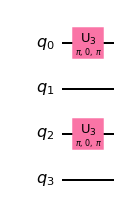

In [10]:
from qiskit_nature.circuit.library import HartreeFock
num_particles=es_problem.num_particles
num_spin_orbitals=es_problem.num_spin_orbitals
initial_state=HartreeFock(num_spin_orbitals,num_particles,jw_converter)

#initial_state.draw('mpl',style='iqx')
circuit_drawer(initial_state.decompose(), output='mpl', plot_barriers=False)
#print(initial_state)

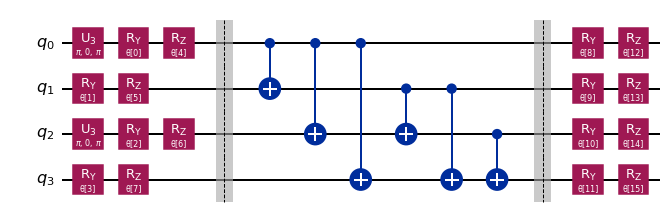

In [55]:
from qiskit.circuit.library import EfficientSU2

num_qubits=qubit_op_jw.num_qubits

SU2_ansatz = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement='full', insert_barriers=True)

SU2_ansatz.compose(initial_state,front=True,inplace=True)

SU2_ansatz.decompose().draw('mpl', style='iqx')

In [56]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
#設定ansatz
SU2_solver=VQE(ansatz=SU2_ansatz,
               quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")))

In [57]:
SU2_result=SU2_solver.compute_minimum_eigenvalue(qubit_op_jw)
print(SU2_result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 374,
    'eigenstate': array([-4.21910345e-08+7.96358281e-08j,  1.62354057e-04-1.55747695e-04j,
       -3.02495406e-08-6.68152633e-08j, -3.33169292e-04+3.97728701e-04j,
        1.08269327e-04+1.57289354e-04j,  7.07616071e-01-7.06596757e-01j,
        1.47236846e-04+3.92261736e-05j, -4.84724533e-07+1.64868533e-06j,
        2.91608944e-08-3.01361459e-08j, -1.82906772e-04-1.21762453e-04j,
        2.04505053e-09-3.34429790e-08j, -1.17374491e-07+1.04935610e-07j,
        2.57307121e-08+5.18349931e-08j,  2.42632543e-04-1.81523557e-04j,
        4.24797730e-08+1.81181296e-08j,  1.09720592e-07-2.97506592e-08j]),
    'eigenvalue': (-1.8369676661830066+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[13]): 0.37913015840003716,
                              ParameterVectorElement(θ[2]): 0.003497934766207961,
                              ParameterVectorElement(θ[1]): 0.001037675913906757,
                              Parame

In [58]:
from qiskit_nature.algorithms import GroundStateEigensolver
calc = GroundStateEigensolver(jw_converter, SU2_solver)
res = calc.solve(es_problem)

print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.836966886862
  - computed part:      -1.836966886862
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.116997892413
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388449]
    - computed part:      [0.0  0.0  1.388449]
  > Dipole moment (a.u.): [0.0  0.0  0.0004997]  Total: 0.0004997
                 (debye): [0.0  0.0  0.00127011]  Total: 0.00127011
 


In [16]:
converge_cnts = np.empty([1], dtype=object)
converge_vals = np.empty([1], dtype=object)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

SU2_solver=VQE(ansatz=SU2_ansatz,
               callback=store_intermediate_result,
               quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")))

SU2_result=SU2_solver.compute_minimum_eigenvalue(qubit_op_jw)

converge_cnts[0] = np.asarray(counts)
converge_vals[0] = np.asarray(values)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


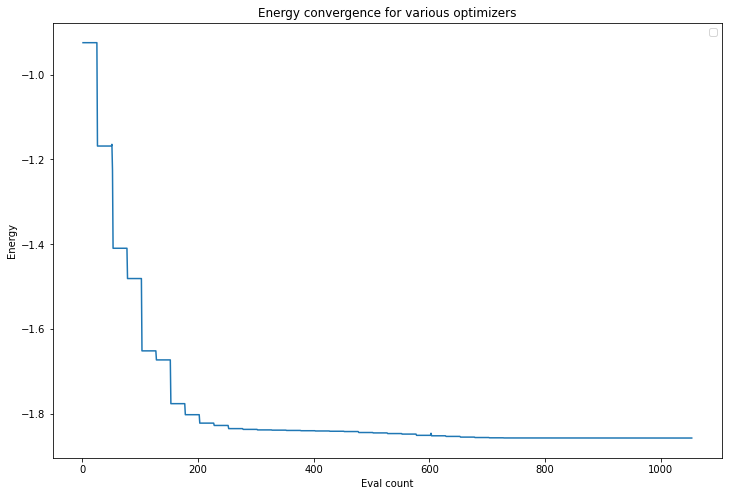

In [17]:
import pylab
pylab.rcParams['figure.figsize'] = (12, 8)

pylab.plot(converge_cnts[0], converge_vals[0])
#, label=type(optimizer).__name__
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

In [50]:
#ibmq runtime
from qiskit import IBMQ

IBMQ.load_account()

provider = IBMQ.get_provider(group="open")
print("Provider supports runtime: ", provider.has_service("runtime"))

backend = provider.get_backend("ibmq_qasm_simulator")

ibmqfactory.load_account:WARNING:2022-04-11 09:50:03,430: Credentials are already in use. The existing account in the session will be replaced.


Provider supports runtime:  True


In [51]:
from qiskit_nature.runtime import VQEProgram

optimizer = {
    "name": "SPSA",
    "maxiter": 50,
}
initial_point = np.random.random(ansatz.num_parameters)
        
runtime_vqe = VQEProgram(
    ansatz=SU2_ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    provider=provider,
    backend=backend,
    shots=1024,
    measurement_error_mitigation=True,
)

In [52]:
runtime_vqe_solver = GroundStateEigensolver(jw_converter, runtime_vqe)

In [53]:
runtime_result = runtime_vqe_solver.solve(es_problem)

In [54]:
print(runtime_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.807823181887
  - computed part:      -1.807823181887
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.087854187438
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.171 S: 0.389 S^2: 0.540 M: -0.093
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.5893197]
    - computed part:      [0.0  0.0  0.5893197]
  > Dipole moment (a.u.): [0.0  0.0  0.799629]  Total: 0.799629
                 (debye): [0.0  0.0  2.032454]  Total: 2.032454
 


In [23]:
#最佳距離
# import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

# qiskit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import ExcitationPreserving
from qiskit import BasicAer
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP

# qiskit nature imports
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.algorithms.pes_samplers import BOPESSampler, Extrapolator

In [24]:
stretch1 = partial(Molecule.absolute_stretching, atom_pair=(1, 0))
mol = Molecule(
    geometry=[("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.3])],
    degrees_of_freedom=[stretch1], 
)

# pass molecule to PSYCF driver
driver = ElectronicStructureMoleculeDriver(mol, driver_type=ElectronicStructureDriverType.PYSCF)

In [25]:
mol.perturbations = [0.2]
print(mol.geometry)

mol.perturbations = [0.6]
print(mol.geometry)

[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.5])]
[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.8999999999999999])]


In [26]:
es_problem = ElectronicStructureProblem(driver)

qubit_converter = QubitConverter(JordanWignerMapper())
quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
solver = VQE(quantum_instance=quantum_instance)

me_gsc = GroundStateEigensolver(qubit_converter, solver)

In [27]:
distance1 = partial(Molecule.absolute_distance, atom_pair=(1, 0))
mol = Molecule(
    geometry=[("H", [0.0, 0.0, 0.0]), ("H", [0.0, 0.0, 0.3])],
    degrees_of_freedom=[distance1],
)

# pass molecule to PSYCF driver
driver = ElectronicStructureMoleculeDriver(mol, driver_type=ElectronicStructureDriverType.PYSCF)

es_problem = ElectronicStructureProblem(driver)


# Specify degree of freedom (points of interest)
points = np.linspace(0.25, 2, 30)
results_full = {}  # full dictionary of results for each condition
results = {}  # dictionary of (point,energy) results for each condition



 # define instance to sampler
bs = BOPESSampler(gss=me_gsc, bootstrap=False, num_bootstrap=None, extrapolator=None)
# execute
res = bs.sample(es_problem, points)
results_full[f"vqe"] = res.raw_results
results[f"points_vqe"] = res.points
results[f"energies_vqe"] = res.energies

In [30]:
# define numpy solver
solver_numpy = NumPyMinimumEigensolver()
me_gsc_numpy = GroundStateEigensolver(qubit_converter, solver_numpy)
bs_classical = BOPESSampler(
    gss=me_gsc_numpy, bootstrap=False, num_bootstrap=None, extrapolator=None
)
# execute
res_np = bs_classical.sample(es_problem, points)
results_full["np"] = res_np.raw_results
results["points_np"] = res_np.points
results["energies_np"] = res_np.energies

Text(0, 0.5, 'Energy')

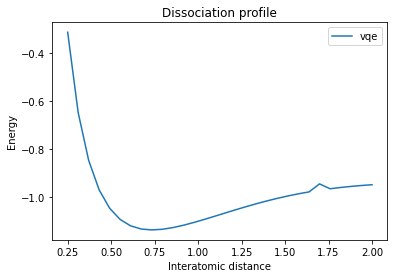

In [32]:
fig = plt.figure()

plt.plot(results[f"points_vqe"], results[f"energies_vqe"], label=f"vqe")
#plt.plot(results["points_np"], results["energies_np"], label="numpy")
plt.legend()
plt.title("Dissociation profile")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

In [44]:
from qiskit.opflow import I, X, Z,Y
H2_op = (-0.4804* I ^ I) + \
        (-0.4347 * I ^ Z) + \
        (0.3435 * Z ^ I) + \
        (0.5716 * Z ^ Z) + \
        (0.0910 * X ^ X) +\
        (0.0910 * Y ^ Y)

print(f'Number of qubits: {H2_op.num_qubits}')

Number of qubits: 2


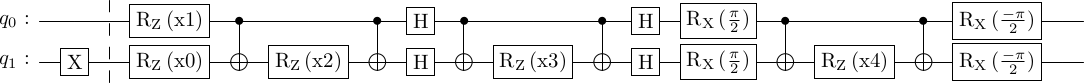

In [57]:
#自己定義ansatz
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import Parameter
from numpy import pi

#定義變數
x0=Parameter('x0')
x1=Parameter('x1')
x2=Parameter('x2')
x3=Parameter('x3')
x4=Parameter('x4')

qreg_q = QuantumRegister(2, 'q')
#creg_c = ClassicalRegister(4, 'c')
my_circuit = QuantumCircuit(qreg_q)#, creg_c


my_circuit.x(qreg_q[1])
my_circuit.barrier(qreg_q[0], qreg_q[1])
my_circuit.rz(x0, qreg_q[1])
my_circuit.rz(x1, qreg_q[0])
my_circuit.cx(qreg_q[0], qreg_q[1])
my_circuit.rz(x2, qreg_q[1])
my_circuit.cx(qreg_q[0], qreg_q[1])
my_circuit.h(qreg_q[0])
my_circuit.h(qreg_q[1])
my_circuit.cx(qreg_q[0], qreg_q[1])
my_circuit.rz(x3, qreg_q[1])
my_circuit.cx(qreg_q[0], qreg_q[1])
my_circuit.h(qreg_q[1])
my_circuit.h(qreg_q[0])
my_circuit.rx(pi/2, qreg_q[1])
my_circuit.rx(pi/2, qreg_q[0])
my_circuit.cx(qreg_q[0], qreg_q[1])
my_circuit.rz(x4, qreg_q[1])
my_circuit.cx(qreg_q[0], qreg_q[1])
my_circuit.rx(-pi/2, qreg_q[1])
my_circuit.rx(-pi/2, qreg_q[0])

#my_circuit.draw()
my_circuit.draw(output="latex")
#my_circuit.draw(output="mpl")

In [49]:
my_solver = VQE(
    ansatz=my_circuit,
    quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")),
)

In [51]:
result2=my_solver.compute_minimum_eigenvalue(H2_op)
print(result2)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 24,
    'eigenstate': array([-2.77555756e-17+5.55111512e-17j, -1.65445581e-05+2.95125130e-05j,
        8.72284782e-01+4.88998219e-01j,  9.81338491e-17-1.57007721e-16j]),
    'eigenvalue': (-1.830199998218372+0j),
    'optimal_parameters': {   Parameter(x1): -2.270427521548869,
                              Parameter(x2): -3.6140910977762406,
                              Parameter(x3): -1.5434319611295328,
                              Parameter(x4): -4.739821013200904,
                              Parameter(x0): -3.9176398778623187},
    'optimal_point': array([-3.91763988, -2.27042752, -3.6140911 , -1.54343196, -4.73982101]),
    'optimal_value': -1.830199998218372,
    'optimizer_evals': None,
    'optimizer_time': 0.06417965888977051}


In [83]:
# Execution Imports
from qiskit import Aer
from qiskit.utils import QuantumInstance

# Algorithm Imports
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import CG
from qiskit.opflow import I, X, Z
from qiskit.circuit import QuantumCircuit, ParameterVector
from scipy.optimize import minimize
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian

# Instantiate the system Hamiltonian
h2_hamiltonian = -1.05 * (I ^ I) + 0.39 * (I ^ Z) - 0.39 * (Z ^ I) - 0.01 * (Z ^ Z) + 0.18 * (X ^ X)

# This is the target energy
h2_energy = -1.85727503

# Define the Ansatz
wavefunction = QuantumCircuit(2)
params = ParameterVector('theta', length=8)

a = Parameter('a')
b = Parameter('b')
c = Parameter('c')
d = Parameter('d')
e = Parameter('e')
f = Parameter('f')
g = Parameter('g')
h = Parameter('h')

wavefunction.ry(a, 0)
wavefunction.ry(b, 1)
wavefunction.rz(c, 0)
wavefunction.rz(d, 1)
wavefunction.cx(0, 1)
wavefunction.ry(e, 0)
wavefunction.ry(f, 1)
wavefunction.rz(g, 0)
wavefunction.rz(h, 1)

# Define the expectation value corresponding to the energy
op = ~StateFn(h2_hamiltonian) @ StateFn(wavefunction)
print(op)

ComposedOp([
  OperatorMeasurement(-1.05 * II
  + 0.39 * IZ
  - 0.39 * ZI
  - 0.01 * ZZ
  + 0.18 * XX),
  CircuitStateFn(
       ┌───────┐┌───────┐     ┌───────┐┌───────┐
  q_0: ┤ Ry(a) ├┤ Rz(c) ├──■──┤ Ry(e) ├┤ Rz(g) ├
       ├───────┤├───────┤┌─┴─┐├───────┤├───────┤
  q_1: ┤ Ry(b) ├┤ Rz(d) ├┤ X ├┤ Ry(f) ├┤ Rz(h) ├
       └───────┘└───────┘└───┘└───────┘└───────┘
  )
])


In [84]:
# Convert the expectation value into an operator corresponding to the gradient w.r.t. the state parameters using
# the parameter shift method.
params=[a,b,c,d,e,f,g,h]
state_grad = Gradient(grad_method='param_shift').convert(operator=op, params=params)
# Print the operator corresponding to the gradient
print(state_grad)
# Assign the parameters and evaluate the gradient
#state_grad_result = state_grad.assign_parameters(value_dict).eval()
#print('State gradient computed with parameter shift', state_grad_result)


ListOp([
  SummedOp([
    -0.525 * ComposedOp([
      OperatorMeasurement(II),
      CircuitStateFn(
           ┌─────────────┐┌───────┐     ┌───────┐┌───────┐
      q_0: ┤ Ry(a + π/2) ├┤ Rz(c) ├──■──┤ Ry(e) ├┤ Rz(g) ├
           └──┬───────┬──┘├───────┤┌─┴─┐├───────┤├───────┤
      q_1: ───┤ Ry(b) ├───┤ Rz(d) ├┤ X ├┤ Ry(f) ├┤ Rz(h) ├
              └───────┘   └───────┘└───┘└───────┘└───────┘
      )
    ]),
    0.525 * ComposedOp([
      OperatorMeasurement(II),
      CircuitStateFn(
           ┌─────────────┐┌───────┐     ┌───────┐┌───────┐
      q_0: ┤ Ry(a - π/2) ├┤ Rz(c) ├──■──┤ Ry(e) ├┤ Rz(g) ├
           └──┬───────┬──┘├───────┤┌─┴─┐├───────┤├───────┤
      q_1: ───┤ Ry(b) ├───┤ Rz(d) ├┤ X ├┤ Ry(f) ├┤ Rz(h) ├
              └───────┘   └───────┘└───┘└───────┘└───────┘
      )
    ]),
    0.195 * ComposedOp([
      OperatorMeasurement(IZ),
      CircuitStateFn(
           ┌─────────────┐┌───────┐     ┌───────┐┌───────┐
      q_0: ┤ Ry(a + π/2) ├┤ Rz(c) ├──■──┤ Ry(e) ├┤ Rz(g) ├
   

In [85]:
grad = Gradient(grad_method='param_shift')

qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'),
                        shots=1,
                        seed_simulator=2,
                        seed_transpiler=2)

#Conjugate Gradient algorithm
optimizer = CG(maxiter=50)

# Gradient callable
vqe = VQE(wavefunction, optimizer=optimizer, gradient=grad, quantum_instance=qi_sv)

result = vqe.compute_minimum_eigenvalue(h2_hamiltonian)
print('Result:', result.optimal_value, 'Reference:', h2_energy)

Result: -1.8404998438048765 Reference: -1.85727503


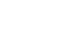

In [59]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit.circuit.library import EfficientSU2

# Choose the ansatz
ansatz_type = "UCCSD"

converter=jw_converter

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 3
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
    
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = initial_state)
    
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = initial_state)
    
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = initial_state)
    
elif ansatz_type == "EfficientSU2":
    ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits, reps=2, entanglement='full', insert_barriers=True)
    
ansatz.draw('mpl', style='iqx')